In [226]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
%matplotlib inline

In [227]:
# Read in training data
train = pd.read_csv("train.csv")
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [228]:
# Check size of training dataframe
train.shape

(9557, 143)

In [229]:
# Read in testing data
test = pd.read_csv("test.csv")
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [230]:
# Transform column names to lowercase without spaces
train.columns = [col.lower().replace(' ','_') for col in train.columns]

test.columns = [col.lower().replace(' ','_') for col in test.columns]

In [231]:
# Check for missing data
train.isnull().sum()[train.isnull().sum() > 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
sqbmeaned       5
dtype: int64

## Investigate Missing Data

In [232]:
# According to the data dictionary, v2a1 stands for 'Monthly rent payment'
# Presumably, if a person owns a house, they won't have monthly rent payment to make
# Let's check if the missing values in v2a1 corresponds to those who own a house in 'tipovivi1'=1

train[(train['v2a1'].isnull()==True) & (train['tipovivi1']==1)].shape

(5911, 143)

In [233]:
# It seems that most of the missing values under v2a1 do correspond to those who own
# We will impute these missing values with 0 

train.loc[(pd.isnull(train['v2a1']) & train['tipovivi1'] == 1), 'v2a1'] = 0

In [234]:
# We still have 949 missing values under 'v2a1' but we have drastically reduced the unknown values

train.isnull().sum()['v2a1']

949

In [235]:
# Check the number of remaining nulls per region

regions = ['lugar1','lugar2','lugar3','lugar4','lugar5','lugar6']

for region in regions:
    num_nulls = train[(train['v2a1'].isnull()==True) & (train[region]==1)].shape[0]
    hh_region = train[train[region]==1].shape[0]
    ratio = num_nulls/hh_region
    print("There are {} number of missing values out of {} households in {}.\nThe ratio of missing values is {}. \n"\
          .format(num_nulls, hh_region, region, round(ratio,4)))

There are 411 number of missing values out of 5616 households in lugar1.
The ratio of missing values is 0.0732. 

There are 78 number of missing values out of 886 households in lugar2.
The ratio of missing values is 0.088. 

There are 117 number of missing values out of 596 households in lugar3.
The ratio of missing values is 0.1963. 

There are 110 number of missing values out of 791 households in lugar4.
The ratio of missing values is 0.1391. 

There are 147 number of missing values out of 897 households in lugar5.
The ratio of missing values is 0.1639. 

There are 86 number of missing values out of 771 households in lugar6.
The ratio of missing values is 0.1115. 



According to our query above, the number of remaining missing values seem to be pretty evenly distributed between each region of Costa Rica which suggests that the information is missing at random and is not inherently related to features of the dataset. 

After further reading ongoing Kaggle disscussions, it also seems that 'v2a1' indicates a null value when households do not rent (aka they own) OR households are not paying loans (aka odd situations such as those labeled precaiours, borrowed or assigned). As a result, we will impute the rest of the null values as 0 as well.

In [236]:
# Impute remaining missing 'v2a1' values to 0

train['v2a1'].fillna(0, inplace = True)

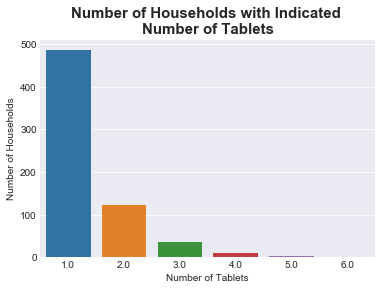

In [237]:
# The next column of concern, v18q1, stands for 'number of tablets household owns'
hh_tablets = train[['idhogar', 'v18q1']].drop_duplicates().groupby('v18q1').count().reset_index()\
                                               .rename(columns ={'v18q1': 'num_tablets', 'idhogar':'num_households'})
    
sns.barplot(x= hh_tablets['num_tablets'], y = hh_tablets['num_households'])
plt.xlabel('Number of Tablets')
plt.ylabel('Number of Households')
plt.title('Number of Households with Indicated \nNumber of Tablets', fontweight = 'bold',fontsize = 15);

In [238]:
# Looking above, we can see there is no value for 0 
# It is very likely that the nan values actually represent 0 tablets owned
# We will therefore impute these nan values with 0

train['v18q1'].fillna(0, inplace = True)

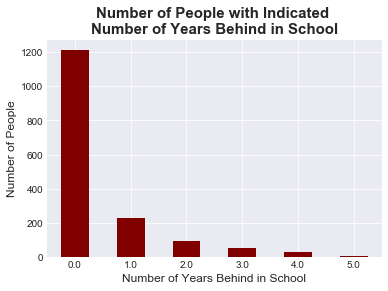

In [239]:
# The next column of concern, rez_esc, stands for 'Years behind in school'
train['rez_esc'].value_counts().plot(kind = 'bar', color = 'maroon', )
plt.xlabel('Number of Years Behind in School', fontsize = 12)
plt.ylabel('Number of People',  fontsize = 12)
plt.title('Number of People with Indicated \nNumber of Years Behind in School', fontweight = 'bold', fontsize = 15)
plt.xticks(rotation = 'horizontal');

Unlike the previous column, we can see that rez_esc already accounts for those with 0 years behind in school. 

From the competition hosts, we know that this variable is only collected for people between 7 and 19 years of age 
and it is the difference between the years of education a person should have and the years of education he/she does have. 

In [240]:
# We will quickly check if the non-missing values are actually reserved for those between 7-19

train[train['rez_esc'].notnull()==True][['age']].describe()

,age
count,1629.000000
mean,12.258441
std,3.218325
min,7.000000
25%,9.000000
50%,12.000000
75%,15.000000
max,17.000000


From above, we can see that data has been collected for those between 7-17 years of age, which is consistent with what the competition host indicated. However, there are only 1629 data points out of 9557 total entries. If we decided to impute all null values to 0 we would not only be diluting the significance of this column, we would also be equating on-time schooling with those who are not in school (either because they are too young or too old). As a result, I will opt to drop this column for now.  

In [241]:
# Drop rez_esc column

train = train.drop('rez_esc', axis = 1)

In [242]:
train[(train['idhogar']=='51e901e19')][['meaneduc']].values[0]

array([ 6.3333335])

In [243]:
round(train[(train['idhogar']=='51e901e19')&(train['age']>=18)]['escolari'].mean(), 5)

6.33333

In [244]:
# The next column of concern, meaneduc, stands for average years of education for adults (18+)
# According to the competition hosts, meaneduc is calculated by averaging the years of education for 
# all those over 18 in a househould
# Before investigating the missing data points, we will check if the calculations are accurate

household_list = []
for household in train['idhogar'].unique():
    avg_ed = train[(train['idhogar']==household)&(train['age']>=18)]['escolari'].mean()
    train_mean_ed = train[(train['idhogar']==household)][['meaneduc']].values[0][0]
    
    if avg_ed != train_mean_ed:
        household_list.append(household)

In [245]:
# There seem to be 689 households with the incorrect meaneduc
# Therefore, as we impute the null values in meaneduc with the calculated average years of education of those 18+, we 
# we will also correct the incorrect meaneduc's.

len(household_list)

689

In [246]:
# Create table of households and average years of education

household_avg_ed = {}
for household in train['idhogar'].unique():
    avg_ed = train[(train['idhogar']==household)&(train['age']>=18)]['escolari'].mean()
    household_avg_ed[household] = avg_ed
    
# Create dataframe with household_avg_ed keys and values as the two columns

household_table = pd.DataFrame({'hh_id': list(household_avg_ed.keys()), 'mean_educ': list(household_avg_ed.values())})

# Merge household_table with train df

train = train.merge(household_table, left_on = 'idhogar', right_on = 'hh_id', how = 'outer').drop('hh_id', axis = 1)

# Change meaneduc values to mean_educ and then drop mean_educ

train['meaneduc'] = train['mean_educ']

train = train.drop('mean_educ', axis = 1)

In [247]:
# Check if there are remaining null values

train['meaneduc'].isnull().sum()

15

In [248]:
# Since we have 15 remaining null values, we will check the ages of those in the households in question

train[train['meaneduc'].isnull()==True][['age','idhogar','meaneduc']]

,age,idhogar,meaneduc
4975,16,896fe6d3e,NaN
5396,10,374ca5a19,NaN
6443,7,bfd5067c2,NaN
6444,13,bfd5067c2,NaN
7461,9,f2bfa75c4,NaN
7462,10,f2bfa75c4,NaN
7463,11,f2bfa75c4,NaN
7705,11,03c6bdf85,NaN
7706,9,03c6bdf85,NaN
7756,16,ad687ad89,NaN


In [249]:
# From above, it seems that the null values in meaneduc correspond to households with only those under 18
# Therefore, we will fill the remaining nulls with 0

train['meaneduc'] = train['meaneduc'].fillna(0)

In [258]:
# The last column of concern is SQBmeaned = square of the mean years of education of adults (>=18) in the household
# As this column interacts with meaneduc,  we will use meaneduc to calculate new values for SQBmeaned

train['sqbmeaned'] = train['meaneduc']**2

In [261]:
# Check for any more missing data
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

## Exploratory Data Analysis

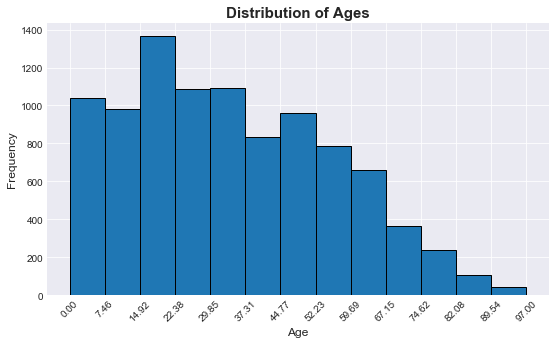

In [49]:
# Let's check the age distribution 

plt.figure(figsize = (9,5))
(n, bins, patches) = plt.hist(x = 'age', bins = 13, data = train, edgecolor = 'black')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Distribution of Ages', fontweight = 'bold', fontsize = 15)
plt.xticks(bins, rotation = 45);
